<a href="https://colab.research.google.com/github/bekku/deeplearning/blob/master/VGG16%E3%81%8B%E3%82%89%E8%92%B8%E7%95%99VGG%E5%9E%8B_WIP(%E7%95%B0%E5%B8%B8%E6%95%B0%E5%80%A4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **import編**

In [ ]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time

!pip install deap

from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

torch.cuda.is_available()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


True

# **教師モデル定義(温度付き・dropout削除)**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self): # , num_classes):
        super(VGG16, self).__init__()
        num_classes=10

        self.block1_output = nn.Sequential (
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block2_output = nn.Sequential (
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block3_output = nn.Sequential (
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block4_output = nn.Sequential (
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block5_output = nn.Sequential (
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  #512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 32 ),  #4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, num_classes),  #4096
        )

    def forward(self, x,T):
        x = self.block1_output(x)
        # print(x.size())
        x = self.block2_output(x)
        # print(x.size())
        x = self.block3_output(x)
        # print(x.size())
        x = self.block4_output(x)
        # print(x.size())
        x = self.block5_output(x)
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        x = x/T
        return f.softmax(x)
VGG16

__main__.VGG16

# **温度付きcross_entropyの損失関数の定義**

In [ ]:
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()

    def forward(self, p, q):
        #pが教師モデル、qが生徒モデルの出力値(既に対数化してます)。
        loss = torch.mul(p,q)
        loss = -torch.sum(loss)
        return loss

# **❌教師モデルの学習**

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training log: 1 epoch (128 / 50000 train. data). Loss: 2.325044631958008
Training log: 1 epoch (11648 / 50000 train. data). Loss: 2.1179797649383545
Training log: 1 epoch (23168 / 50000 train. data). Loss: 2.027575731277466
Training log: 1 epoch (34688 / 50000 train. data). Loss: 1.9160300493240356
Training log: 1 epoch (46208 / 50000 train. data). Loss: 1.8972350358963013
0.20074
0.2019
Training log: 2 epoch (128 / 50000 train. data). Loss: 1.8911463022232056
Training log: 2 epoch (11648 / 50000 train. data). Loss: 1.8029321432113647
Training log: 2 epoch (23168 / 50000 train. data). Loss: 1.8023442029953003
Training log: 2 epoch (34688 / 50000 train. data). Loss: 1.72959566116333
Training log: 2 epoch (46208 / 50000 train. data). Loss: 1.6573724746704102
0.33432
0.334
Training log: 3 epoch (128 / 50000 train. data). Loss: 1.6409320831298828
Training log: 3 epoch (11648 / 50000 train. data). Loss:

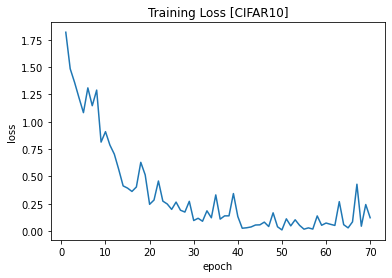

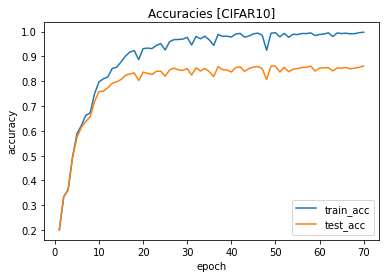

In [ ]:
if __name__ == '__main__':
    epoch = 70

    loader = load_cifar10()


    net: VGG16 = VGG16()
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    # optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    # もしGPUが使えるなら使う
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)


    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for e in range(epoch):
        
        ################################### 学習 #################################
        
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device)  # to GPU?
            labels = labels.to(device)
            optimizer.zero_grad()
            output = net(images,1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            if i % 90 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )


        history['train_loss'].append(loss.item())

        
        
        ################################### 推論 #################################
        
        
        net.eval()
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['train']):
                images = images.to(device)  # to GPU?
                labels = labels.to(device)
                outputs = net(images,1)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 50000)
        print(acc)
        history['train_acc'].append(acc)

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)  # to GPU?
                labels = labels.to(device)
                outputs = net(images,1)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 10000)
        print(acc)
        history['test_acc'].append(acc)
        
    #====== 保存 =======
    torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
    plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

# **教師の出力(s_max,a_max)の設定**

In [ ]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_max=0
for i in range(10):
    t1 = time.time()
    correct = 0
    with torch.no_grad():
        for images, labels in loader['test']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = Tnet(images,1)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    t2 = time.time()
    s_max += t2-t1
a_max = float(correct / 10000)
print(a_max)
t2 = time.time()
s_max /= 10
print(f"経過時間：{s_max}")

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.8499
経過時間：2.719150996208191


# **VGG型生成モデル**

入力

[フィルタ_1、フィルタ_2、フィルタ_3、フィルタ_4、、、]

よくない点：0の層があるとpoolingを行えないため、最後の全結合層で時間がかかるため0がないほど速度が速くなってしまう。また、0が混じった個体の学習時間が著しく長くなってしまう。poolingはしよう。


In [ ]:
class CreateVGG(torch.nn.Module):
    def __init__(self, VGG_model_list):
        super(CreateVGG, self).__init__()
        self.count = 0
        self.VGG_model_list_2=[]
        for i in range(len(VGG_model_list)):
            if VGG_model_list[i]==0:continue
            else:
                self.VGG_model_list_2.append(VGG_model_list[i])

        PRE_FILTER = 3
        for i in range(len(self.VGG_model_list_2)):
            FILTER = self.VGG_model_list_2[i]
            if i==0 and len(self.VGG_model_list_2)-5 > i:
                self._modules["fc"+str(1)] = nn.Sequential (
                    nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                    nn.BatchNorm2d(FILTER),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(FILTER, FILTER, kernel_size=3, padding=1),
                    nn.BatchNorm2d(FILTER),
                    nn.ReLU(inplace=True),
                    )
                PRE_FILTER=FILTER
            elif len(self.VGG_model_list_2)-5 <= i:
                self.count += 1
                self._modules["fc"+str(i+1)] = nn.Sequential (
                    nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                    nn.BatchNorm2d(FILTER),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(FILTER, FILTER, kernel_size=3, padding=1),
                    nn.BatchNorm2d(FILTER),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    )
                PRE_FILTER=FILTER
            else:
                self._modules["fc"+str(i+1)] = nn.Sequential(
                    nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                    nn.BatchNorm2d(FILTER),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(FILTER, FILTER, kernel_size=3, padding=1),
                    nn.BatchNorm2d(FILTER),
                    nn.ReLU(inplace=True),
                    )
                PRE_FILTER=FILTER


        fil = 32//(2**self.count)
        self.classifier = nn.Sequential(
            nn.Linear(PRE_FILTER*fil**2, PRE_FILTER*fil**2), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER*fil**2, (PRE_FILTER*fil**2)//2 ), 
            nn.ReLU(True),
            nn.Linear((PRE_FILTER*fil**2)//2, 10), 
        )
        

    def forward(self, x, T):
        for i in range(len(self.VGG_model_list_2)):
            x = f.relu(self._modules["fc"+str(i + 1)](x))
            # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        # print(x.size())
        x = x/T
        return f.log_softmax(x)

In [ ]:
print( CreateVGG([16]))
net_2: torch.nn.Module = CreateVGG([16])
net: VGG16 = VGG16()
for i,j in loader['test']:
    net(i,10)
    net_2(i,10)
    break

CreateVGG(
  (fc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=2048, out_features=10, bias=True)
  )
)
torch.Size([128, 64, 16, 16])
torch.Size([128, 128, 8, 8])
torch.Size([128, 256, 4, 4])
torch.Size([128, 512, 2, 2])
torch.Size([128, 512, 1, 1])
torch.Size([128, 512])
torch.Size([128, 16, 16, 16])
torch.Size([128, 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# **速度と精度の評価関数(最大化予定)**

In [30]:
def speed_acc_normalization(spe_max,spe_min,spe,acc_max,acc_min,acc):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe+1) - spe_min) / ( (spe_max - spe_min) * 2 )*0.5
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (acc - acc_min) / ( (acc_max - acc_min) * 2 )*0.5
    else:
        accuracy_normalization=0
    print("--------------------------------------------------------------------------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    print("--------------------------------------------------------------------------------")

    return speed_normalization + accuracy_normalization

# **⭐️教師モデルの出力をリスト化(GA時の計算量削減のため)**

# **蒸留学習epochがこの出力で決まる**

In [ ]:
# 学習データの出力(教師出力)をリストとしてメモ化
loaders = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
Tnet.to(device)

max_model_outputs_list = []
epoch = 10
temp = 10

for e in range(1,epoch+1):
    with torch.no_grad():
        for i,(images, labels) in enumerate(loaders['train']):
            images = images.to(device)
            labels = labels.to(device)
            # GPUのままリスト化するとCUDA OUT of MEMORYとなる？
            max_model_outputs_list.append([images.to('cpu'),Tnet(images,temp).to('cpu')])
    
    print("epoch : {} ".format(e))

print("出力")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch : 1 
epoch : 2 
epoch : 3 
epoch : 4 
epoch : 5 
epoch : 6 
epoch : 7 
epoch : 8 
epoch : 9 
epoch : 10 
出力


# **評価関数 evaluater(メモ化) の定義**

In [ ]:
loaders = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
Tnet.to(device)

#　遺伝的評価関数、引数 : gane=層ごとの2の条数-リスト、temp = 温度、スピード最大、精度最大。
def evaluater(gane):
    # 入力された乗数から、本当のモデルのノード数とする。
    model_gane=[]
    gane_number=[0,32,64,128,256,512,1024]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])
    
    # epoch = 20
    # temp = 1000

    net: torch.nn.Module = CreateVGG(model_gane)
    net.to(device)

    # optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
    criterion = T_S_Closs_entropy()

    """　学習　開始"""
    loss = None
    net.train()
    for i,data in enumerate(max_model_outputs_list):
        data_one = data[0].to(device)
        output = net(data_one,temp)

        optimizer.zero_grad()
        loss = criterion(data[1].to(device),output)

        loss.backward()
        optimizer.step()
        

        if i%(782)==0:
            print("実行割合 : {}/5 ,epoch : {} ,loss : {}".format(1+i//(782),(1+i//(782))*2,loss.item()))
        # if i % 391 == 0:
        #     print("実行割合 : {}/10 ,epoch : {} ,loss : {}".format(1+i//(391),(1+i//(391)),loss.item()))


    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.time()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device) 
            labels = labels.to(device)
            #　蒸留モデルは、推論時は温度を1に戻します。
            outputs = net(images,1)
            _, predicted = torch.max(outputs.data, 1)
            #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
            correct += (predicted == labels).sum().item()

    acc = float(correct / 10000)
    t2 = time.time()
    elapsed_time = t2-t1

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    return (speed_acc_normalization(s_max,0,elapsed_time,a_max,0,acc),)
print("出力")

Files already downloaded and verified
Files already downloaded and verified
出力


# **1個体の蒸留時間確認(最大ノード数、最大層数で入力してみよう)**

In [ ]:
t1 = time.time()
print(evaluater([1,1,2,2]))
t2 = time.time()
print(t2-t1)
# net: torch.nn.Module = CreateVGG([512,256,512,1024,256])
# net.to(device)
# def kansuu():
#     correct = 0
#     t1 = time.time()
#     with torch.no_grad():
#         for images, labels in loaders['test']:
#             images = images.to(device) 
#             labels = labels.to(device)
#             #　蒸留モデルは、推論時は温度を1に戻します。
#             outputs = net(images,1)
#             _, predicted = torch.max(outputs.data, 1)
#             #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
#             correct += (predicted == labels).sum().item()

#     acc = float(correct / 10000)
#     t2 = time.time()
#     elapsed_time = t2-t1

#     # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
#     return (speed_acc_normalization(s_max,0,elapsed_time,a_max,0,acc),)
# kansuu()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


実行割合 : 1/10 ,epoch : 1 ,loss : 294.73089599609375
実行割合 : 2/10 ,epoch : 2 ,loss : 291.85772705078125
実行割合 : 3/10 ,epoch : 3 ,loss : 290.19281005859375
実行割合 : 4/10 ,epoch : 4 ,loss : 291.09173583984375
実行割合 : 5/10 ,epoch : 5 ,loss : 291.4736328125
実行割合 : 6/10 ,epoch : 6 ,loss : 289.9588623046875
----------------
速度:2.4477431774139404 ,精度:0.5516
速度評価値:0.2967685439585495 ,精度評価値:0.32295081967213113
評価指標:0.6197193636306806
----------------
(0.6197193636306806,)
26.851404428482056


In [ ]:
# t1 = time.time()
# evaluater([5,4,0,5,6,4])
# t2 = time.time()
# print(t2-t1)
print(CreateVGG([512,256,0,512,1024,256]))
nnnet: torch.nn.Module = CreateVGG([512,256,0,512,1024,256])
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
nnnet.to(device)
t1 = time.time()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = nnnet(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        break
print(float(correct / 10000))
t2 = time.time()
print(f"経過時間：{t2-t1}")

In [ ]:
t1 = time.time()
evaluater([6,6,6,6,6,6,6,6,6,6])
t2 = time.time()
print(t2-t1)

# **⭐️GAのNNモデル探索**

In [ ]:
import random
from deap import base, creator, tools

# NNモデルの最大の層
VGG_max_sou=5

# NNモデルの最大のノード数
VGG_max_nodel=5

# 適応度クラスの作成
# 最大化したい場合1.0
# 最小化したい場合-1.0
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# 個体クラスの作成
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolboxの作成
toolbox = base.Toolbox()

# 遺伝子を生成する関数"attr_gene"を登録
# 0~14の値をランダムに生成する。
toolbox.register("attr_gene", random.randrange, 0, VGG_max_nodel)

# 個体を生成する関数”individual"を登録
# initRepeat(creator.Individual,遺伝子生成関数, N)
# N回遺伝子生成関数を実行し、creator.Individualに格納して返す関数
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_gene, VGG_max_sou)

# 世代(個体集団)を生成する関数"population"を登録
# 個体生成したものを集めて、世代化
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数"evaluate"を登録
toolbox.register("evaluate", evaluater)

# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

# 変異を行う関数"mutate"を登録
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = VGG_max_nodel, indpb=0.2)
#ランダム0~14の値を、個体を上書き(0.2の確率(個体の要素に対して))

# 個体選択法"select"を登録
toolbox.register("select", tools.selTournament, tournsize=3)


def main():

    random.seed()

    # GAパラメータ
    N_GEN = 20      # 繰り返し世代数
    POP_SIZE = 20   # 集団内の個体数
    CX_PB = 0.7     # 交叉確率
    MUT_PB = 0.05    # 変異確率0.05

    # 個体集団の生成
    pop = toolbox.population(n=POP_SIZE)
    print("遺伝的探索開始")
    print(pop)

    # 個体集団の適応度の評価
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print("  Evaluated %i individuals" % len(pop))
    # 適応度の抽出
    fits = [ind.fitness.values[0] for ind in pop]

    print("-----------------------")
    # 進化ループ開始
    g = 0
    while g < N_GEN:

        g = g + 1
        print("-- Generation %i --" % g)

        # 次世代個体の選択・複製
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        print(offspring)

        # 交叉
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # 交叉させる個体を選択
            if random.random() < CX_PB:
                toolbox.mate(child1, child2)

                # 交叉させた個体は適応度を削除する
                del child1.fitness.values
                del child2.fitness.values

        # 変異
        for mutant in offspring:

            # 変異させる個体を選択
            if random.random() < MUT_PB:
                print("変異前:{}".format(mutant))
                toolbox.mutate(mutant)
                print("変異後:{}".format(mutant))

                # 変異させた個体は適応度を削除する
                del mutant.fitness.values


        # 適応度を削除した個体について適応度の再評価を行う
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        print(invalid_ind)
        fitnesses = map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print("  Evaluated %i individuals" % len(invalid_ind))

        # 個体集団を新世代個体集団で更新
        pop[:] = offspring

        # 新世代の全個体の適応度の抽出
        fits = [ind.fitness.values[0] for ind in pop]

        # 適応度の統計情報の出力
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)


    print("-- End of (successful) evolution --")

    # 最良個体の抽出
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


if __name__ == '__main__':

    main()

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


遺伝的探索開始
[[1, 1, 2, 3, 0], [4, 2, 0, 0, 2], [4, 2, 2, 2, 2], [3, 3, 4, 4, 1], [2, 3, 2, 4, 2], [0, 2, 1, 2, 4], [1, 2, 2, 0, 1], [4, 4, 3, 0, 2], [0, 2, 0, 4, 2], [2, 2, 2, 3, 0], [3, 2, 3, 1, 3], [4, 3, 2, 0, 2], [2, 2, 3, 0, 4], [4, 3, 3, 4, 2], [1, 2, 4, 3, 3], [4, 3, 0, 2, 0], [1, 4, 4, 1, 0], [4, 4, 1, 0, 4], [4, 3, 1, 0, 2], [3, 4, 1, 1, 3]]
実行割合 : 1/5 ,epoch : 2 ,loss : 294.73077392578125
実行割合 : 2/5 ,epoch : 4 ,loss : 290.3438720703125
実行割合 : 3/5 ,epoch : 6 ,loss : 291.40057373046875
実行割合 : 4/5 ,epoch : 8 ,loss : 290.8594970703125
実行割合 : 5/5 ,epoch : 10 ,loss : 291.39178466796875
----------------
速度:2.454171895980835 ,精度:0.631
速度評価値:0.29586609257406815 ,精度評価値:0.3694379391100703
評価指標:0.6653040316841384
----------------
実行割合 : 1/5 ,epoch : 2 ,loss : 294.7312316894531
実行割合 : 2/5 ,epoch : 4 ,loss : 290.2255859375
実行割合 : 3/5 ,epoch : 6 ,loss : 291.34527587890625
実行割合 : 4/5 ,epoch : 8 ,loss : 290.88165283203125
実行割合 : 5/5 ,epoch : 10 ,loss : 291.46661376953125
----------------
速度:4.557

# **最適モデルの蒸留学習**

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 500 ,epoch : 1 ,Loss: 182.48699951171875
accuracy:0.2938
temp: 500 ,epoch : 2 ,Loss: 181.17054748535156
accuracy:0.4124
temp: 500 ,epoch : 3 ,Loss: 182.33963012695312
accuracy:0.4955
temp: 500 ,epoch : 4 ,Loss: 181.80889892578125
accuracy:0.49
temp: 500 ,epoch : 5 ,Loss: 182.17967224121094
accuracy:0.5532
temp: 500 ,epoch : 6 ,Loss: 182.05755615234375
accuracy:0.5692
temp: 500 ,epoch : 7 ,Loss: 181.89463806152344
accuracy:0.5728
temp: 500 ,epoch : 8 ,Loss: 180.68019104003906
accuracy:0.5971
temp: 500 ,epoch : 9 ,Loss: 181.2438201904297
accuracy:0.5587
temp: 500 ,epoch : 10 ,Loss: 182.17459106445312
accuracy:0.6112
temp: 500 ,epoch : 11 ,Loss: 181.79685974121094
accuracy:0.6448
temp: 500 ,epoch : 12 ,Loss: 180.86203002929688
accuracy:0.6296
temp: 500 ,epoch : 13 ,Loss: 181.85008239746094
accuracy:0.6534
temp: 500 ,epoch : 14 ,Loss: 182.1682891845703
accuracy:0.6536
temp: 500 ,epoch : 15 ,Loss: 181.2371826171875
accuracy:0.6706
temp: 500 ,epoch : 16 ,Loss: 181.90460205078125
accura

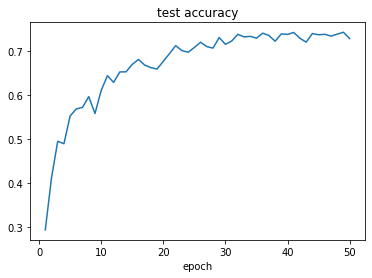

In [ ]:
epoch = 50
temp = 500
gane_number=[0,32,64,128,256,512,1024]
net: torch.nn.Module = CreateVGG([gane_number[1], gane_number[2], gane_number[2], gane_number[3], gane_number[0]])
loaders = load_cifar10()

Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

criterion = T_S_Closs_entropy()
criterion2 = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)
        max_model_outputs = Tnet(data,temp)

        optimizer.zero_grad()
        output = net(data,temp) 
        loss = criterion(max_model_outputs,output)
        loss.backward()
        optimizer.step()

    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))

t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/2020-07-1週目/CNN_最適モデル_soft_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

# **最適モデルの評価確認**

In [ ]:
net: torch.nn.Module = CreateVGG([gane_number[1], gane_number[2], gane_number[2], gane_number[3], gane_number[0]])
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/CNN_最適モデル_soft_1.pth')
net.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
s_CNN_max = 0
for i in range(10):
    t1 = time.time()
    correct = 0
    with torch.no_grad():
        for images, labels in loader['test']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = net(images,1)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    t2 = time.time()
    s_CNN_max += t2-t1
a_CNN_max = float(correct / 10000)
t2 = time.time()
s_CNN_max /= 10
print(speed_acc_normalization(s_max,0,s_CNN_max,a_max,0,a_CNN_max))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------
速度:2.508129525184631 ,精度:0.7349
速度評価値:0.2882916223788639 ,精度評価値:0.43026932084309133
評価指標:0.7185609432219553
----------------
0.7185609432219553




---

---



---





# **VGG生成モデル②**

入力[n_1, n_2, , , ,  n_N]

VGG16(正確にはconvが13層)を生成しモデルが作られる。

In [ ]:
class CreateVGG_2(torch.nn.Module):
    def __init__(self, VGG_model_list):
        super(CreateVGG_2, self).__init__()
        self.count = 0

        PRE_FILTER = 3
        for i in range(len(VGG_model_list)):
            if VGG_model_list[i]!=0:
                FILTER = VGG_model_list[i]
                self._modules["fc"+str(i+1)] = nn.Sequential (
                nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                nn.BatchNorm2d(FILTER),
                nn.ReLU(inplace=True),
                )
                PRE_FILTER=FILTER

        self.classifier = nn.Sequential(
            nn.Linear(PRE_FILTER, PRE_FILTER), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER, PRE_FILTER//2 ), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER//2, 10), 
        )
        self.pool = torch.nn.MaxPool2d(2, 2) 
        

    def forward(self, x, T):
        for i in range(1,14):
            if "fc"+str(i) in self._modules:
                x = f.relu(self._modules["fc"+str(i)](x))
                # print(x.size())
            if i==2 or i==4 or i==7 or i==10 or i==13:
                x = self.pool(x)
                # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        # print(x.size())
        x = x/T
        return f.log_softmax(x)

In [ ]:
print( CreateVGG_2([16,0,0,0,0,0,16,0,0,32,0,0,0]))
net_2: torch.nn.Module = CreateVGG_2([16,0,0,0,0,0,16,0,0,32,0,0,0])
net: VGG16 = VGG16()
for i,j in loader['test']:
    net(i,10)
    net_2(i,10)
    break

CreateVGG_2(
  (fc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc7): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc10): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# **学習データの出力(教師出力)をリストとしてメモ化**

In [ ]:
loaders = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
Tnet.to(device)

max_model_outputs_list = []
epoch = 10
temp = 10

for e in range(1,epoch+1):
    with torch.no_grad():
        for i,(images, labels) in enumerate(loaders['train']):
            images = images.to(device)
            # GPUのままリスト化するとCUDA OUT of MEMORYとなる？
            max_model_outputs_list.append([images.to('cpu'),Tnet(images,temp).to('cpu')])
    
    print("epoch : {} ".format(e))


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch : 1 
epoch : 2 
epoch : 3 
epoch : 4 
epoch : 5 
epoch : 6 
epoch : 7 
epoch : 8 
epoch : 9 
epoch : 10 


# **評価evaluater関数の定義**

In [ ]:
loaders = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
Tnet.to(device)

#　遺伝的評価関数、引数 : gane=層ごとの2の条数-リスト、temp = 温度、スピード最大、精度最大。
def evaluater_2(gane):
    # 入力された乗数から、本当のモデルのノード数とする。
    model_gane=[]
    gane_number=[0,32,64,128,256,512,1024]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    criterion = T_S_Closs_entropy()

    """　学習　開始"""
    loss = None
    net.train()
    for e in range(len(max_model_outputs_list)):
        data_one = max_model_outputs_list[e][0].to(device)
        output = net(data_one,temp)

        optimizer.zero_grad()
        loss = criterion(max_model_outputs_list[e][1].to(device),output)

        loss.backward()
        optimizer.step()

        if e % 782 == 0:
            print("実行割合 : {}/5 ,epoch : {} ,loss : {}".format(1+e//(782),(1+e//(782))*2,loss.item()))
        # if i % 391 == 0:
        #     print("実行割合 : {}/10 ,epoch : {} ,loss : {}".format(1+i//(391),(1+i//(391)),loss.item()))


    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.time()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device) 
            labels = labels.to(device)
            #　蒸留モデルは、推論時は温度を1に戻します。
            outputs = net(images,1)
            _, predicted = torch.max(outputs.data, 1)
            #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
            correct += (predicted == labels).sum().item()

    acc = float(correct / 10000)
    t2 = time.time()
    elapsed_time = t2-t1

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    return (speed_acc_normalization(s_max,0,elapsed_time,a_max,0,acc),)
print("出力")

Files already downloaded and verified
Files already downloaded and verified
出力


# **個体の蒸留時間確認(最大ノード数、最大層数で入力してみよう)**

In [ ]:
# [0,32,64,128,256,512,1024]
# evaluater_2([2,2,3,3,4,4,4,5,5,5,5,5,5])
evaluater_2([2,0,0,0,0,0,0,0,0,0,0,0,0])

CreateVGG_2(
  (fc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
実行割合 : 1/5 ,epoch : 2 ,loss : 295.5843505859375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


実行割合 : 2/5 ,epoch : 4 ,loss : 261.2047424316406
実行割合 : 3/5 ,epoch : 6 ,loss : 253.07537841796875
実行割合 : 4/5 ,epoch : 8 ,loss : 243.3883056640625
実行割合 : 5/5 ,epoch : 10 ,loss : 241.57598876953125
----------------
速度:2.332160711288452 ,精度:0.4369
速度評価値:0.31299379250401604 ,精度評価値:0.2557962529274005
評価指標:0.5687900454314165
----------------


(0.5687900454314165,)

# **⭐️GAのNNモデル探索**

In [ ]:
import random
from deap import base, creator, tools

# NNモデルの最大の層
VGG_max_sou = 13

# NNモデルの最大のノード数
VGG_max_nodel = 6

# 適応度クラスの作成
# 最大化したい場合1.0
# 最小化したい場合-1.0
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# 個体クラスの作成
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolboxの作成
toolbox = base.Toolbox()

# 遺伝子を生成する関数"attr_gene"を登録
# 0~14の値をランダムに生成する。
toolbox.register("attr_gene", random.randrange, 0, VGG_max_nodel)

# 個体を生成する関数”individual"を登録
# initRepeat(creator.Individual,遺伝子生成関数, N)
# N回遺伝子生成関数を実行し、creator.Individualに格納して返す関数
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_gene, VGG_max_sou)

# 世代(個体集団)を生成する関数"population"を登録
# 個体生成したものを集めて、世代化
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数"evaluate"を登録
toolbox.register("evaluate", evaluater_2)

# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

# 変異を行う関数"mutate"を登録
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = VGG_max_nodel, indpb=0.2)
#ランダム0~14の値を、個体を上書き(0.2の確率(個体の要素に対して))

# 個体選択法"select"を登録
toolbox.register("select", tools.selTournament, tournsize=3)


def main():

    random.seed()

    # GAパラメータ
    N_GEN = 20      # 繰り返し世代数
    POP_SIZE = 20   # 集団内の個体数
    CX_PB = 0.7     # 交叉確率
    MUT_PB = 0.05    # 変異確率0.05

    # 個体集団の生成
    pop = toolbox.population(n=POP_SIZE)
    print("遺伝的探索開始")
    print(pop)

    # 個体集団の適応度の評価
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print("  Evaluated %i individuals" % len(pop))
    # 適応度の抽出
    fits = [ind.fitness.values[0] for ind in pop]

    print("-----------------------")
    # 進化ループ開始
    g = 0
    while g < N_GEN:

        g = g + 1
        print("-- Generation %i --" % g)

        # 次世代個体の選択・複製
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        print(offspring)

        # 交叉
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # 交叉させる個体を選択
            if random.random() < CX_PB:
                toolbox.mate(child1, child2)

                # 交叉させた個体は適応度を削除する
                del child1.fitness.values
                del child2.fitness.values

        # 変異
        for mutant in offspring:

            # 変異させる個体を選択
            if random.random() < MUT_PB:
                print("変異前:{}".format(mutant))
                toolbox.mutate(mutant)
                print("変異後:{}".format(mutant))

                # 変異させた個体は適応度を削除する
                del mutant.fitness.values


        # 適応度を削除した個体について適応度の再評価を行う
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        print(invalid_ind)
        fitnesses = map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print("  Evaluated %i individuals" % len(invalid_ind))

        # 個体集団を新世代個体集団で更新
        pop[:] = offspring

        # 新世代の全個体の適応度の抽出
        fits = [ind.fitness.values[0] for ind in pop]

        # 適応度の統計情報の出力
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)


    print("-- End of (successful) evolution --")

    # 最良個体の抽出
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


if __name__ == '__main__':

    main()

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


遺伝的探索開始
[[2, 5, 4, 4, 3, 3, 4, 0, 2, 0, 4, 0, 1], [4, 2, 2, 4, 1, 1, 5, 1, 4, 0, 4, 2, 0], [5, 3, 3, 4, 5, 1, 1, 5, 5, 0, 5, 2, 1], [5, 5, 2, 1, 4, 3, 4, 2, 3, 0, 5, 4, 1], [1, 2, 1, 5, 4, 5, 3, 0, 5, 5, 1, 1, 0], [3, 1, 1, 2, 2, 0, 3, 0, 0, 0, 3, 1, 4], [1, 1, 2, 1, 0, 1, 5, 2, 1, 0, 3, 4, 5], [5, 4, 3, 2, 4, 2, 0, 2, 2, 4, 3, 4, 5], [4, 4, 4, 3, 0, 0, 1, 3, 0, 0, 3, 0, 1], [2, 2, 3, 3, 1, 4, 3, 2, 1, 3, 1, 0, 5], [5, 4, 5, 2, 0, 4, 1, 0, 2, 1, 4, 5, 3], [4, 5, 4, 3, 1, 3, 4, 1, 2, 2, 4, 0, 1], [5, 4, 3, 3, 0, 5, 5, 2, 4, 3, 1, 4, 2], [4, 5, 0, 4, 5, 2, 5, 4, 5, 0, 0, 1, 4], [1, 3, 0, 0, 1, 0, 5, 1, 1, 1, 5, 5, 4], [4, 3, 2, 3, 0, 1, 3, 3, 4, 4, 3, 3, 3], [4, 3, 0, 2, 5, 2, 1, 4, 3, 5, 1, 0, 5], [5, 3, 2, 3, 1, 2, 2, 2, 4, 1, 5, 3, 3], [3, 5, 0, 1, 3, 0, 0, 0, 4, 0, 4, 1, 0], [0, 4, 0, 2, 1, 1, 3, 3, 4, 5, 4, 5, 0]]
実行割合 : 1/5 ,epoch : 2 ,loss : 294.74310302734375
実行割合 : 2/5 ,epoch : 4 ,loss : 183.12835693359375
実行割合 : 3/5 ,epoch : 6 ,loss : 182.15235900878906
実行割合 : 4/5 ,epoch : 8 ,l

# **最適モデルの蒸留学習**

In [ ]:
epoch = 50
temp = 10
model_gane=[]
gane_number=[0,32,64,128,256,512,1024]
gane_in = [1, 1, 1, 1, 0, 1, 5, 2, 1, 0, 3, 0, 0]
for i in gane_in:
    if gane_number[i]!=0:
        model_gane.append(gane_number[i])

net: torch.nn.Module = CreateVGG_2(model_gane)

loaders = load_cifar10()

Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

criterion = T_S_Closs_entropy()
criterion2 = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)
        max_model_outputs = Tnet(data,temp)

        optimizer.zero_grad()
        output = net(data,temp) 
        loss = criterion(max_model_outputs,output)
        loss.backward()
        optimizer.step()

    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))

t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/2020-07-1週目/CNN_最適モデル_soft_2.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10 ,epoch : 1 ,Loss: 131.40574645996094
accuracy:0.54
temp: 10 ,epoch : 2 ,Loss: 124.77244567871094
accuracy:0.628
temp: 10 ,epoch : 3 ,Loss: 120.07997131347656
accuracy:0.7063
temp: 10 ,epoch : 4 ,Loss: 114.49989318847656
accuracy:0.727
temp: 10 ,epoch : 5 ,Loss: 118.77175903320312
accuracy:0.7456
temp: 10 ,epoch : 6 ,Loss: 114.00543975830078
accuracy:0.7633
temp: 10 ,epoch : 7 ,Loss: 103.728759765625
accuracy:0.7769
temp: 10 ,epoch : 8 ,Loss: 112.91027069091797
accuracy:0.7866
temp: 10 ,epoch : 9 ,Loss: 110.87250518798828
accuracy:0.7861
temp: 10 ,epoch : 10 ,Loss: 124.964599609375
accuracy:0.8045
temp: 10 ,epoch : 11 ,Loss: 111.75173950195312
accuracy:0.7885
temp: 10 ,epoch : 12 ,Loss: 90.42561340332031
accuracy:0.7917
temp: 10 ,epoch : 13 ,Loss: 105.47268676757812
accuracy:0.8052
temp: 10 ,epoch : 14 ,Loss: 107.91912078857422
accuracy:0.8205
temp: 10 ,epoch : 15 ,Loss: 96.20149230957031
accuracy:0.8135
temp: 10 ,epoch : 16 ,Loss: 99.19638061523438
accuracy:0.8144
temp: 10 ,ep

# **最適モデルと教師モデルのCPU評価確認**

In [ ]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cpu')
Tnet.to(device)
s_cpu_max=0

t1 = time.time()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.time()
s_cpu_max += t2-t1
a_cpu_max = float(correct / 10000)
print(a_cpu_max)
t2 = time.time()
s_cpu_max /= 3
print(f"経過時間：{s_cpu_max}")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.8508
経過時間：19.163785298665363


In [ ]:
model_gane=[]
gane_number=[0,32,64,128,256,512,1024]
gane_in = [1, 1, 1, 1, 0, 1, 5, 2, 1, 0, 3, 0, 0]
for i in gane_in:
    if gane_number[i]!=0:
        model_gane.append(gane_number[i])

net: torch.nn.Module = CreateVGG_2(model_gane)

param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/CNN_最適モデル_soft_2.pth')
net.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cpu')
net.to(device)
s_CNN_max = 0
t1 = time.time()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = net(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.time()
s_CNN_max += t2-t1
a_CNN_max = float(correct / 10000)
t2 = time.time()
s_CNN_max /= 10
print(speed_acc_normalization(s_cpu_max,0,s_CNN_max,a_cpu_max,0,a_CNN_max))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------------------------------------
速度:1.3971042394638062 ,精度:0.8322
速度評価値:0.48963920140841216 ,精度評価値:0.4890691114245416
評価指標:0.9787083128329538
--------------------------------------------------------------------------------
0.9787083128329538


# **最適モデルと教師モデルのCPU評価確認**

In [31]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/VGG16_weight_1.pth')
Tnet.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_cpu_max=0

t1 = time.time()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.time()
s_cpu_max += t2-t1
a_cpu_max = float(correct / 10000)
print(a_cpu_max)
t2 = time.time()
s_cpu_max /= 3
print(f"経過時間：{s_cpu_max}")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.8529
経過時間：0.9042226473490397


In [32]:
model_gane=[]
gane_number=[0,32,64,128,256,512,1024]
gane_in = [1, 1, 1, 1, 0, 1, 5, 2, 1, 0, 3, 0, 0]
for i in gane_in:
    if gane_number[i]!=0:
        model_gane.append(gane_number[i])

net: torch.nn.Module = CreateVGG_2(model_gane)

param = torch.load('/content/gdrive/My Drive/研究コード/2020-07-1週目/CNN_最適モデル_soft_2.pth')
net.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
s_CNN_max = 0
t1 = time.time()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = net(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.time()
s_CNN_max += t2-t1
a_CNN_max = float(correct / 10000)
t2 = time.time()
s_CNN_max /= 10
print(speed_acc_normalization(s_cpu_max,0,s_CNN_max,a_cpu_max,0,a_CNN_max))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


--------------------------------------------------------------------------------
速度:0.17857208251953124 ,精度:0.8322
速度評価値:0.4771088652470426 ,精度評価値:0.24393246570524096
評価指標:0.7210413309522836
--------------------------------------------------------------------------------
0.7210413309522836
